## Доверительные интервалы. Распределение Бернулли с неизвестной вероятностью успеха

**Задача.** Пусть дана выборка из распределения Бернулли (можно считать, например, это это клики по рекламному баннеру в Интернете) длины $n=290$ и вероятностью успеха, равномерно распределенной на $[0.01,0.05]$. Оценить параметр успеха. Построить для него доверительные интервалы: (1) асимптотический, основанный на центральной предельной теореме, (2) доверительный интервал Уилсона. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np # для генерации случайных величин и работы с массивами
import statsmodels.stats.proportion # для построения доверительных интервалов в модели Бернулли 
import datetime
import os
import sqlite3
from scipy import stats
import pandas as pd
import sqlite3
from scipy.stats import chisquare, randint



In [2]:
np.random.seed(123) # фиксируем seed

In [3]:
# Фиксируем параметры задачи

n = 290 # размер выборки 
alpha = 0.05 # параметр ошибки

p = np.random.uniform(0.01,0.05) # неизвестный параметр успеха
p = 1/3

In [4]:
if not os.path.exists('tosses.db'):
    conn = sqlite3.connect('tosses.db')
    cur = conn.cursor()
    # Make some fresh tables using executescript()
    cur.executescript('''CREATE TABLE "timelog" (
    "stamp" TEXT,
    "roll"    INTEGER,
    PRIMARY KEY("stamp")
    );''')
    conn.commit()
    cur.close()


def add_roll(result, cur_time):
    try:
        sqlite_con = sqlite3.connect('tosses.db')
        cursor = sqlite_con.cursor()
        sqlite_insert = """INSERT INTO 'timelog'
                ('stamp', 'roll')
                VALUES (?, ?);"""
        data_tuple = (cur_time, result)
        cursor.execute(sqlite_insert, data_tuple)
        sqlite_con.commit()
        sqlite_con.close()
    except sqlite3.Error as error:
        print("Error while working with sqlite", error)


def pvalue_binom(data):
    res = []
    n = len(np.unique(data))
    for i in np.unique(data):
        res.append(stats.binom_test(len(data[data==i]), len(data), 1/n, alternative = 'two-sided'))
    return(res)

def ci_wilson_print(data, alpha=0.05):
    n = len(np.unique(data))
    data_size = len(data)
    for i in np.unique(data):
        CI_Wilsoni = statsmodels.stats.proportion.proportion_confint(len(data[data==i]), data_size, alpha, method = 'wilson')
        print(f'Доверительный интервал {i} Уилсона равен {CI_Wilsoni}')
        
    


Доверительный интервал 1 Уилсона равен (0.1370170590639374, 0.432461358094338)
Доверительный интервал 2 Уилсона равен (0.2916173598052002, 0.622278323626455)
Доверительный интервал 3 Уилсона равен (0.16095800156300613, 0.4659232933074994)
PV Хиквадрат теста 0.3678794411714425
PV p каждое значение равно 1/n :[0.44899056365532375, 0.18289463579178455, 0.705671978101602]
Доверительный интервал 2 Уилсона равен  (0.2916173598052002, 0.622278323626455)


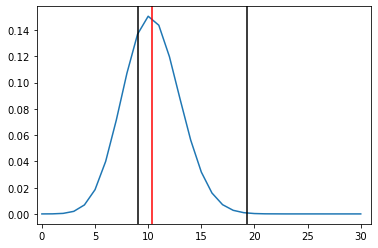

In [6]:
new_roll = ''
con = sqlite3.connect("tosses.db")


# Start a loop that will run until the user enters 'quit'.
while new_roll != 'quit':
    # Ask the user for a name.
    new_roll = input('what did it roll? (type quit to exit)')

    # Add the new roll 
    if new_roll != 'quit':
        try:
            roll_value = int(new_roll)
            print(f'заношу {roll_value}')
            add_roll(roll_value, datetime.datetime.now())

        except ValueError:
            print(f'введено "{new_roll}", нужно вводить целове число')
    
    df = pd.read_sql_query("SELECT * from timelog", con)
    sample = df.roll.values
    ci_wilson_print(sample, alpha=alpha)
    print("PV Хиквадрат теста", chisquare(np.unique(sample, return_counts=True)[1])[1])
    print(f'PV p каждое значение равно 1/n :{pvalue_binom(sample)}')

    


con.close()

CI_Wilson2 = statsmodels.stats.proportion.proportion_confint(len(sample[sample==2]), len(sample), alpha, method = 'wilson')
print("Доверительный интервал 2 Уилсона равен ", CI_Wilson2)
n = len(sample)
F_H0 = stats.binom(n, 1/len(np.unique(sample)))

x = [int(i) for i in np.linspace(0,n-1,1000)]

plt.plot(x, F_H0.pmf(x))
plt.xlim(-0.5, n) 
plt.axvline(x=n/len(np.unique(sample)), c='red')
plt.axvline(x=CI_Wilson2[0]*n, c='black')
plt.axvline(x=CI_Wilson2[1]*n, c='black')
plt.show()



In [7]:
# Сгенерируем выборку из нужного распределения
sample = np.random.binomial(1,p, size=n)
sample = np.array([1,2,3,3,3,2,2,2,2,2,1,3,1,1,3,3,1,2])



# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("tosses.db")
df = pd.read_sql_query("SELECT * from timelog", con)

# Verify that result of SQL query is stored in the dataframe
print(df.head())

con.close()

                        stamp  roll
0  2021-06-30 16:42:09.469770     1
1  2021-06-30 16:42:13.720220     2
2  2021-06-30 16:42:20.903245     3
3  2021-06-30 16:42:24.637841     3
4  2021-06-30 16:42:26.211745     3


In [8]:
df.roll.values

array([1, 2, 3, 3, 3, 2, 2, 2, 2, 2, 1, 3, 1, 1, 3, 3, 1, 2, 1, 3, 3, 2,
       1, 2, 2, 2, 2, 2, 1, 3, 2], dtype=int64)

In [9]:
sample

array([1, 2, 3, 3, 3, 2, 2, 2, 2, 2, 1, 3, 1, 1, 3, 3, 1, 2])

In [10]:
sample = df.roll.values
sample

array([1, 2, 3, 3, 3, 2, 2, 2, 2, 2, 1, 3, 1, 1, 3, 3, 1, 2, 1, 3, 3, 2,
       1, 2, 2, 2, 2, 2, 1, 3, 2], dtype=int64)

In [11]:
sample[sample==1]

array([1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [12]:
print("Истинное значение параметра: ",p)
print("Оценка вероятности успеха: ",len(sample[sample==1])/len(sample))

Истинное значение параметра:  0.3333333333333333
Оценка вероятности успеха:  0.25806451612903225


Для того, чтобы построить доверительный интервал в модели Бернулли, можно воспользоваться методом proportion_confint  класса statsmodels.stats.proportion. Подробнее можно прочитать тут: https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html

В целом, про доверительные интервалы в модели Бернулли можно почитать либо в английской Википедии: 
https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval  
либо в этой статье:  
http://medstatistic.ru/articles/doveritelnye-intervaly-dlya-chastot-i-doley.pdf

In [13]:
sum(sample)

63

In [14]:
CI_Normal = statsmodels.stats.proportion.proportion_confint(len(sample[sample==1]), len(sample), alpha, method = 'normal')
print("Асимптотический доверительный интервал на основе ЦПТ равен ", CI_Normal)

Асимптотический доверительный интервал на основе ЦПТ равен  (0.10403127218279784, 0.41209776007526666)


In [15]:
CI_Wilson = statsmodels.stats.proportion.proportion_confint(len(sample[sample==1]), len(sample), alpha, method = 'wilson')
print("Доверительный интервал 1 Уилсона равен ", CI_Wilson)

Доверительный интервал 1 Уилсона равен  (0.1370170590639374, 0.432461358094338)


In [16]:
CI_Wilson2 = statsmodels.stats.proportion.proportion_confint(len(sample[sample==2]), len(sample), alpha, method = 'wilson')
print("Доверительный интервал 2 Уилсона равен ", CI_Wilson2)

Доверительный интервал 2 Уилсона равен  (0.2916173598052002, 0.622278323626455)


In [17]:
CI_Wilson = statsmodels.stats.proportion.proportion_confint(len(sample[sample==3]), len(sample), alpha, method = 'wilson')
print("Доверительный интервал 2 Уилсона равен ", CI_Wilson)

Доверительный интервал 2 Уилсона равен  (0.16095800156300613, 0.4659232933074994)


In [18]:
from statsmodels.stats.proportion import samplesize_confint_proportion
sufficient_size = int(np.ceil(samplesize_confint_proportion(1/3, 0.005))) 
sufficient_size

34147

In [19]:
chisquare(np.unique(sample, return_counts=True)[1])[1]

0.3678794411714425

In [20]:
s2= randint.rvs(1, 4, size=1300)

In [21]:
chisquare(np.unique(randint.rvs(1, 4, size=1300), return_counts=True)[1])[1]


0.11054775357728734

In [22]:
CI_Wilson = statsmodels.stats.proportion.proportion_confint(len(s2[s2==3]), len(s2), alpha, method = 'wilson')
print("Доверительный интервал 2 Уилсона равен ", CI_Wilson)

Доверительный интервал 2 Уилсона равен  (0.3094859258891552, 0.36071937622715505)


In [23]:

stats.binom_test(len(sample[sample==1]), len(sample), 1/3, alternative = 'two-sided')

0.44899056365532375

In [24]:
stats.binom_test(len(sample[sample==2]), len(sample), 1/3, alternative = 'two-sided')

0.18289463579178455

In [25]:
stats.binom_test(len(sample[sample==3]), len(sample), 1/3, alternative = 'two-sided')

0.705671978101602

In [26]:
len(sample)

31

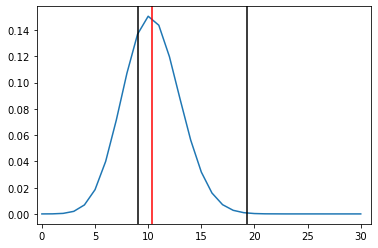

In [27]:

n = len(sample)
F_H0 = stats.binom(n, 1/3)

x = [int(i) for i in np.linspace(0,n-1,1000)]

plt.plot(x, F_H0.pmf(x))
plt.xlim(-0.5, n) 
plt.axvline(x=n/3, c='red')
plt.axvline(x=CI_Wilson2[0]*n, c='black')
plt.axvline(x=CI_Wilson2[1]*n, c='black')

plt.show()